In [19]:
import numpy as np
import matplotlib.pyplot as plt
import halo_exchange
from pprint import pprint
from time import perf_counter

# Serial Code

## Initial Condition

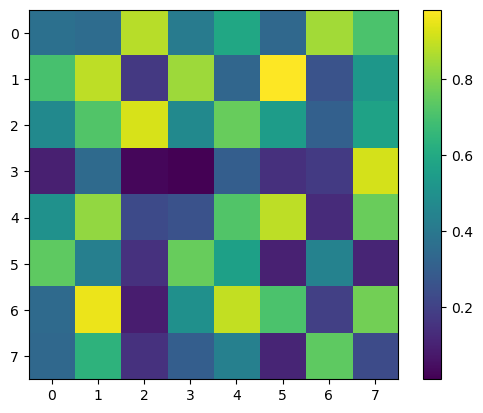

In [20]:
# a simple case with size 8,8
# mesh_2d = np.random.random((8,8))
# mesh_2d = np.random.randint(1,10,(8,8))
# pprint(mesh_2d)
# mesh_2d = np.array([[9, 6, 3, 7, 8, 8, 5, 9],
#                     [7, 8, 9, 8, 2, 2, 9, 3],
#                     [6, 3, 7, 5, 4, 5, 9, 8],
#                     [1, 5, 7, 3, 2, 8, 1, 6],
#                     [6, 2, 7, 3, 3, 5, 9, 7],
#                     [8, 8, 7, 1, 1, 4, 2, 4],
#                     [5, 2, 5, 1, 5, 1, 5, 9],
#                     [6, 4, 7, 6, 5, 1, 1, 9]])

# randomly generated initial condition
mesh_2d = np.array([[0.36957142, 0.35448541, 0.87534055, 0.41334616, 0.58921851,
                     0.33873342, 0.84686359, 0.70661254],
                    [0.70057196, 0.88576827, 0.16987487, 0.84091359, 0.33203134,
                     0.98150579, 0.25927917, 0.52427803],
                    [0.46945511, 0.71938923, 0.92161953, 0.47165736, 0.75622128,
                     0.54595177, 0.30856705, 0.56784142],
                    [0.09464055, 0.34605817, 0.02577937, 0.00983891, 0.30026129,
                     0.1449963, 0.17470095, 0.91703354],
                    [0.50243758, 0.82406356, 0.22732425, 0.25323539, 0.71764112,
                     0.88660062, 0.13041651, 0.76067969],
                    [0.74190659, 0.42878908, 0.14753486, 0.75686801, 0.56198465,
                     0.09739528, 0.44083451, 0.11082951],
                    [0.34638461, 0.95217675, 0.08757205, 0.49765066, 0.89150327,
                     0.70783763, 0.19393284, 0.77442823],
                    [0.33802426, 0.63746115, 0.14900671, 0.30016339, 0.43270171,
                     0.11015575, 0.73895399, 0.23091873]])
# pprint(mesh_2d)
plt.imshow(mesh_2d)
plt.colorbar()

## SAME padding simulation

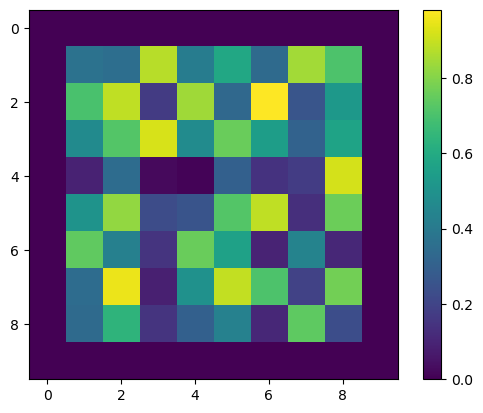

In [21]:
# set up a very simple stencil calculation
# simulate SAME padding
mesh_2d = np.pad(mesh_2d, (1, 1), 'constant', constant_values=(0,))
plt.imshow(mesh_2d)
plt.colorbar()

## Stencil computation

In [22]:
# dominant loop
mesh_2d_new = np.zeros_like(mesh_2d)
start = perf_counter()
for t in range(1000):
    np.save('serial_steps/serial_{}'.format(t),mesh_2d)
    for i in range(1, 9):
        for j in range(1, 9):
            # print(i,' ', j)
            mesh_2d_new[i][j] = mesh_2d[i][j] + (mesh_2d[i-1][j] + mesh_2d[i+1]
                                                 [j] + mesh_2d[i][j-1] + mesh_2d[i][j+1])*0.25

    # np.save('serial_steps/serial_{}'.format(t),mesh_2d_new)
    mesh_2d = np.copy(mesh_2d_new) # timestepping: note that we need a new copy, not referencing the original data
    # np.save('serial_steps/serial_{}'.format(t),mesh_2d)
end = perf_counter()
print("[TOTAL TIME] {}".format(end - start))


[TOTAL TIME] 0.21667950006667525


## Ground Truth

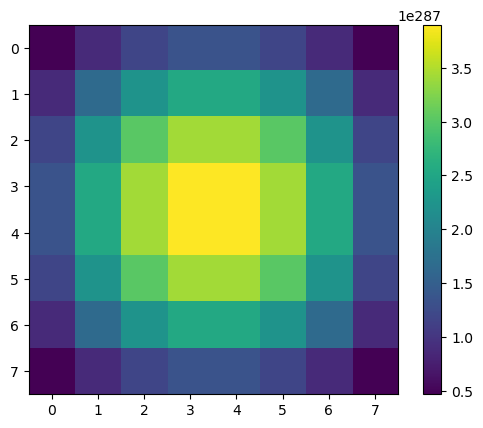

In [23]:
plt.imshow(mesh_2d[1:-1, 1:-1])
plt.colorbar()
# pprint(mesh_2d[1:-1, 1:-1])

# Parallel Code

## Code implementation

In [24]:
%%writefile decomposed_stencil.py

from time import perf_counter
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
from mpi4py import MPI
import halo_exchange
from re import sub

mesh = np.array([[0.36957142, 0.35448541, 0.87534055, 0.41334616, 0.58921851,
                  0.33873342, 0.84686359, 0.70661254],
                 [0.70057196, 0.88576827, 0.16987487, 0.84091359, 0.33203134,
                  0.98150579, 0.25927917, 0.52427803],
                 [0.46945511, 0.71938923, 0.92161953, 0.47165736, 0.75622128,
                  0.54595177, 0.30856705, 0.56784142],
                 [0.09464055, 0.34605817, 0.02577937, 0.00983891, 0.30026129,
                  0.1449963, 0.17470095, 0.91703354],
                 [0.50243758, 0.82406356, 0.22732425, 0.25323539, 0.71764112,
                  0.88660062, 0.13041651, 0.76067969],
                 [0.74190659, 0.42878908, 0.14753486, 0.75686801, 0.56198465,
                  0.09739528, 0.44083451, 0.11082951],
                 [0.34638461, 0.95217675, 0.08757205, 0.49765066, 0.89150327,
                  0.70783763, 0.19393284, 0.77442823],
                 [0.33802426, 0.63746115, 0.14900671, 0.30016339, 0.43270171,
                  0.11015575, 0.73895399, 0.23091873]])

# mesh = np.array([[9, 6, 3, 7, 8, 8, 5, 9],
#                  [7, 8, 9, 8, 2, 2, 9, 3],
#                  [6, 3, 7, 5, 4, 5, 9, 8],
#                  [1, 5, 7, 3, 2, 8, 1, 6],
#                  [6, 2, 7, 3, 3, 5, 9, 7],
#                  [8, 8, 7, 1, 1, 4, 2, 4],
#                  [5, 2, 5, 1, 5, 1, 5, 9],
#                  [6, 4, 7, 6, 5, 1, 1, 9]])

sub_x, sub_y, current_domain = halo_exchange.domain_decomposition_2D(
    mesh, 8, 8, is_periodic=(False, False))
# current_domain = halo_exchange.structured_halo_update_2D(current_domain).numpy().reshape(10,6)
current_domain = halo_exchange.structured_halo_update_2D(current_domain)

# print(type(current_domain))

rank = halo_exchange.rank
current_domain_new = np.zeros_like(current_domain)

start = perf_counter()
for t in range(1000):
    
    np.save('parallel_steps/parallel_{}_{}'.format(rank,t),current_domain)
    for i in range(1, sub_x+1):
        for j in range(1, sub_y+1):
            current_domain_new[i][j] = current_domain[i][j] + (current_domain[i-1][j] + current_domain[i+1]
                                                               [j] + current_domain[i][j-1] + current_domain[i][j+1])*0.25

    print("[CALCULATED DOMAIN {}]".format(rank), current_domain_new)
    # np.save('parallel_steps/parallel_{}_{}'.format(rank,t),current_domain_new)
    # current_domain = halo_exchange.structured_halo_update_2D(current_domain).numpy().reshape(10,6) # update the halo at each time step
    # update the halo at each time step
    current_domain = np.copy(current_domain_new)
    current_domain = halo_exchange.structured_halo_update_2D(current_domain)
    # np.save('parallel_steps/parallel_{}_{}'.format(rank,t),current_domain)
    

end = perf_counter()
print("[TOTAL TIME] {}".format(end - start))
np.save('ans_{}.npy'.format(rank), current_domain[1:-1, 1:-1])

Overwriting decomposed_stencil.py


Here you might need to run the parallelisation manually.

In [27]:
# ! rm -rf ans_*
! mpiexec -n 2 python decomposed_stencil.py
# ! mpirun -np 2 python decomposed_stencil.py
# ! python decomposed_stencil.py

## Compare result

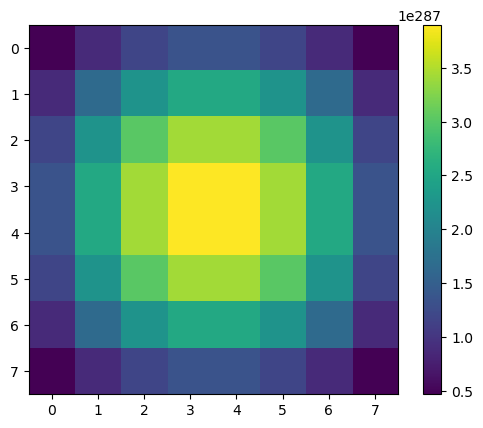

In [29]:
a1 = np.load("ans_0.npy")
a2 = np.load("ans_1.npy")
# a3 = np.load("ans_2.npy")
# a4 = np.load("ans_3.npy")

p_mesh = np.concatenate([a1, a2], axis=1)

# row1 = np.concatenate([a1,a2],axis=1)
# row2 = np.concatenate([a3,a4],axis=1)
# p_mesh = np.concatenate([row1,row2],axis=0)

plt.imshow(p_mesh)
plt.colorbar()


In [30]:
print(mesh_2d[1:-1, 1:-1])
print(p_mesh)

[[4.70302650e+286 8.83879859e+286 1.19084811e+287 1.35418251e+287
  1.35418251e+287 1.19084811e+287 8.83879859e+286 4.70302650e+286]
 [8.83879859e+286 1.66115076e+287 2.23806237e+287 2.54503062e+287
  2.54503062e+287 2.23806237e+287 1.66115076e+287 8.83879859e+286]
 [1.19084811e+287 2.23806237e+287 3.01533327e+287 3.42891048e+287
  3.42891048e+287 3.01533327e+287 2.23806237e+287 1.19084811e+287]
 [1.35418251e+287 2.54503062e+287 3.42891048e+287 3.89921313e+287
  3.89921313e+287 3.42891048e+287 2.54503062e+287 1.35418251e+287]
 [1.35418251e+287 2.54503062e+287 3.42891048e+287 3.89921313e+287
  3.89921313e+287 3.42891048e+287 2.54503062e+287 1.35418251e+287]
 [1.19084811e+287 2.23806237e+287 3.01533327e+287 3.42891048e+287
  3.42891048e+287 3.01533327e+287 2.23806237e+287 1.19084811e+287]
 [8.83879859e+286 1.66115076e+287 2.23806237e+287 2.54503062e+287
  2.54503062e+287 2.23806237e+287 1.66115076e+287 8.83879859e+286]
 [4.70302650e+286 8.83879859e+286 1.19084811e+287 1.35418251e+287
  1

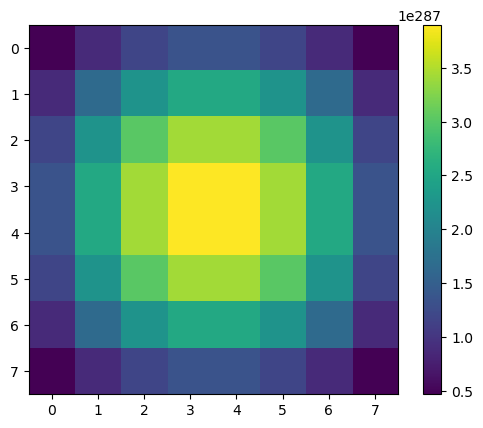

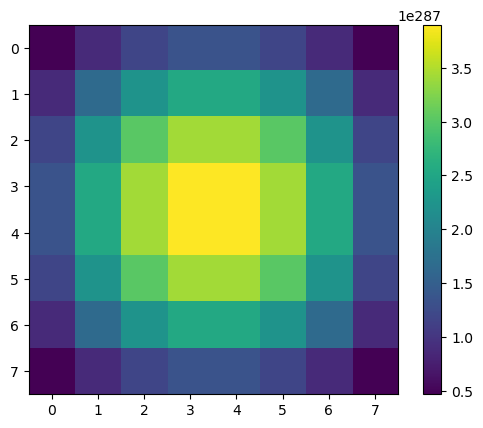

In [31]:
plt.imshow(mesh_2d[1:-1, 1:-1])
plt.colorbar()
plt.show()

plt.imshow(p_mesh)
plt.colorbar()
plt.show()

0.0
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
0.0
0.0


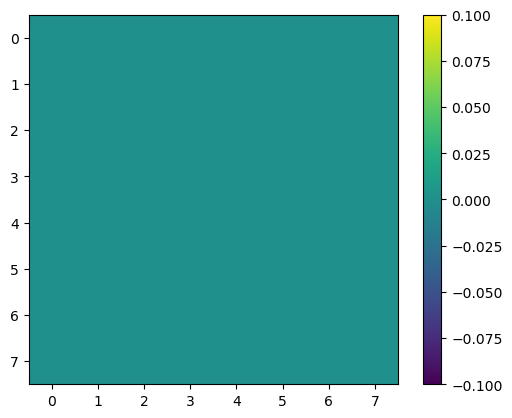

In [32]:
abe = np.abs(p_mesh - mesh_2d[1:-1, 1:-1])
plt.imshow(abe)
plt.colorbar()
print(np.sum(abe))
print(abe)
print(np.max(abe))
print(np.min(abe))
# print(np.where(abe!=0))

## Study the accuracy error

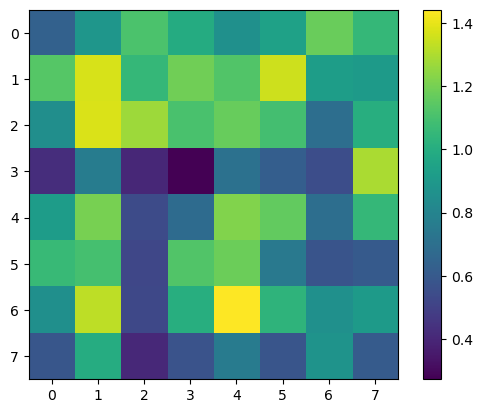

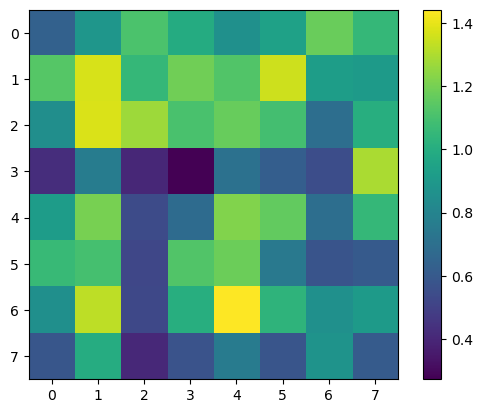

In [33]:
s1 = np.load("serial_steps/serial_1.npy")
# plt.imshow(s1)
plt.imshow(s1[1:-1,1:-1])
plt.colorbar()
plt.show()

p_0 = np.load("parallel_steps/parallel_0_1.npy")
p_1 = np.load("parallel_steps/parallel_1_1.npy")
p_step1 = np.concatenate([p_0[1:-1,1:-1],p_1[1:-1,1:-1]], axis=1)
plt.imshow(p_step1)
plt.colorbar()
plt.show()

In [34]:
# pprint(s1)
pprint(s1)

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.63333576, 0.88715547, 1.10976716, 0.98971432,
        0.86024624, 0.94313039, 1.17301987, 1.04939794, 0.        ],
       [0.        , 1.13177066, 1.37184864, 1.05078535, 1.18764102,
        1.12399613, 1.35050472, 0.92458279, 0.90771131, 0.        ],
       [0.        , 0.84810555, 1.3751145 , 1.26829474, 1.10380569,
        1.16869672, 1.09377437, 0.69551038, 1.00531108, 0.        ],
       [0.        , 0.42412827, 0.76202635, 0.40198959, 0.27257226,
        0.70743569, 0.62187496, 0.5499543 , 1.29283905, 0.        ],
       [0.        , 0.91759026, 1.20021583, 0.53997754, 0.68115346,
        1.21816161, 1.15921292, 0.69612045, 1.05024958, 0.        ],
       [0.        , 1.06130941, 1.09520952, 0.52267321, 1.1219694 ,
        1.17783657, 0.74670963, 0.57397805, 0.60481512, 0.        ],
       [0.        , 0.85441151, 1.3272284

In [35]:
pprint(p_0)

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.63333576, 0.88715547, 1.10976716, 0.98971432,
        0.86024624],
       [0.        , 1.13177066, 1.37184864, 1.05078535, 1.18764102,
        1.12399613],
       [0.        , 0.84810555, 1.3751145 , 1.26829474, 1.10380569,
        1.16869672],
       [0.        , 0.42412827, 0.76202635, 0.40198959, 0.27257226,
        0.70743569],
       [0.        , 0.91759026, 1.20021583, 0.53997754, 0.68115346,
        1.21816161],
       [0.        , 1.06130941, 1.09520952, 0.52267321, 1.1219694 ,
        1.17783657],
       [0.        , 0.85441151, 1.32722847, 0.5241643 , 1.00667734,
        1.44154693],
       [0.        , 0.5839857 , 0.99726308, 0.40530586, 0.57000316,
        0.75815731],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]])


In [36]:
pprint(p_1)

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.98971432, 0.86024624, 0.94313039, 1.17301987, 1.04939794,
        0.        ],
       [1.18764102, 1.12399613, 1.35050472, 0.92458279, 0.90771131,
        0.        ],
       [1.10380569, 1.16869672, 1.09377437, 0.69551038, 1.00531108,
        0.        ],
       [0.27257226, 0.70743569, 0.62187496, 0.5499543 , 1.29283905,
        0.        ],
       [0.68115346, 1.21816161, 1.15921292, 0.69612045, 1.05024958,
        0.        ],
       [1.1219694 , 1.17783657, 0.74670963, 0.57397805, 0.60481512,
        0.        ],
       [1.00667734, 1.44154693, 1.03108442, 0.85944643, 0.9083485 ,
        0.        ],
       [0.57000316, 0.75815731, 0.58002908, 0.87270582, 0.60926428,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]])


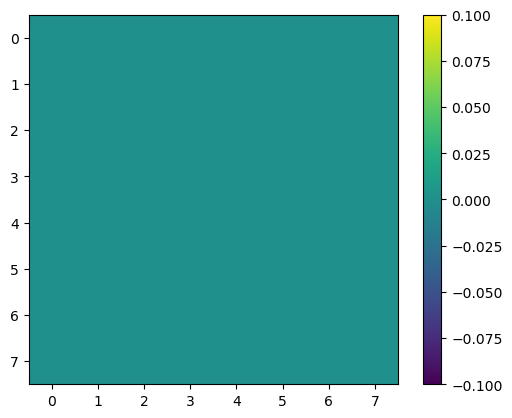

[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


In [37]:
err = np.abs(s1[1:-1,1:-1] - p_step1)
plt.imshow(err)
plt.colorbar()
plt.show()
print(err)